### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

Описание датасета:
Id - идентификационный номер квартиры
DistrictId - идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

##### Импортируемые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import norm
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

##### Функции загрузки, проверки, обучения и сохранения данных

In [2]:
def load_and_optimise(fname):
    df = pd.read_csv(fname)
    df['Rooms'] = df['Rooms'].astype('int64')
    df['HouseFloor'] = df['HouseFloor'].astype('int64')
    df = optimizing_df(df)
    return df

def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})
    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)
    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')
    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())
    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')
    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')
    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

def df_fix_square(df,sigma):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})
    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')
    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df

def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100
    df_na = df_na.drop(
    df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

def add_cluster_year(df):
    scaler = MinMaxScaler()
    train_cluster = train.copy()
    train_cluster = df_fix_house_year_manual(train_cluster)
    train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])
    kmeans_model = KMeans(n_clusters=5, random_state=100)
    agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)
    train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

def add_mean_price(df, df_train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})
    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})
    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

def data_prepare(df, df_train):
    all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
    all_data.drop(['Price'], axis=1, inplace=True)
    mu, sigma = norm.fit(all_data['Square'])
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df,sigma)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df

def show_pred():
    plt.figure(figsize = (16, 8))
    model_pred = model.predict(X_test)
    r2 = r2_score(y_test, model_pred)
    mse = mean_squared_error(y_test, model_pred)
    plt.scatter(y_test, (model_pred - y_test), color='lime')
    plt.xlabel("Прогноз")
    plt.title("Распределение предсказаний")
    plt.legend([f'Точность= {r2:.4f}'])
    plt.axhline(0, color='b')
    plt.show()

def show_price():
    target_mean = train['Price'].mean()
    target_median = train['Price'].median()
    target_mode = train['Price'].mode()[0]
    plt.figure(figsize = (16, 8))
    plt.hist(train['Price'], density=True, bins=50, alpha=0.5)
    y = np.linspace(0, 0.000005, 10)
    plt.plot([target_mean] * 10, y, label='среднее',  linewidth=4)
    plt.plot([target_median] * 10, y, label='медиана',  linewidth=4)
    plt.plot([target_mode] * 10, y, label='частое', linewidth=4)
    plt.xlabel("Стоимость")
    plt.ylabel("Плотность")
    plt.title('Плотность распределения стоимости недвижимости')
    plt.legend()
    plt.show()
    
def show_features(): 
    df_num_features=train.copy()
    df_num_features = df_num_features.select_dtypes(include=['float64', 'float32', 'float16'])
    df_num_features.drop('Price', axis=1, inplace=True)
    df_num_features.hist(figsize=(16,16), bins=20, grid=False);
    
def model_train():
    features = list(train.loc[:,train.columns != 'Id'].corrwith(train['Price']).abs().
                    sort_values(ascending=False)[1:].index)
    target = 'Price'
    X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], test_size=0.2, random_state=82)
    X_train = data_prepare(X_train, train)
    X_test = data_prepare(X_test, train)
    model = RandomForestRegressor(n_estimators=1700,n_jobs=-1)
    model.fit(X_train, y_train)
    return model,X_train, X_test, y_train, y_test

def save(fname,test):
    test_features = list(X_train.columns)
    test = data_prepare(test,train)
    test['Price'] = model.predict(test[test_features])
    test[['Id', 'Price']].to_csv(fname, index=None)

#### Основной(main) код программы

In [3]:
test=load_and_optimise('test.csv')
train=load_and_optimise('train.csv')
model,X_train, X_test, y_train, y_test=model_train()
save('Rogochiy_predictions.csv',test)

#### Диаграммы распределения недвижимости по признакам

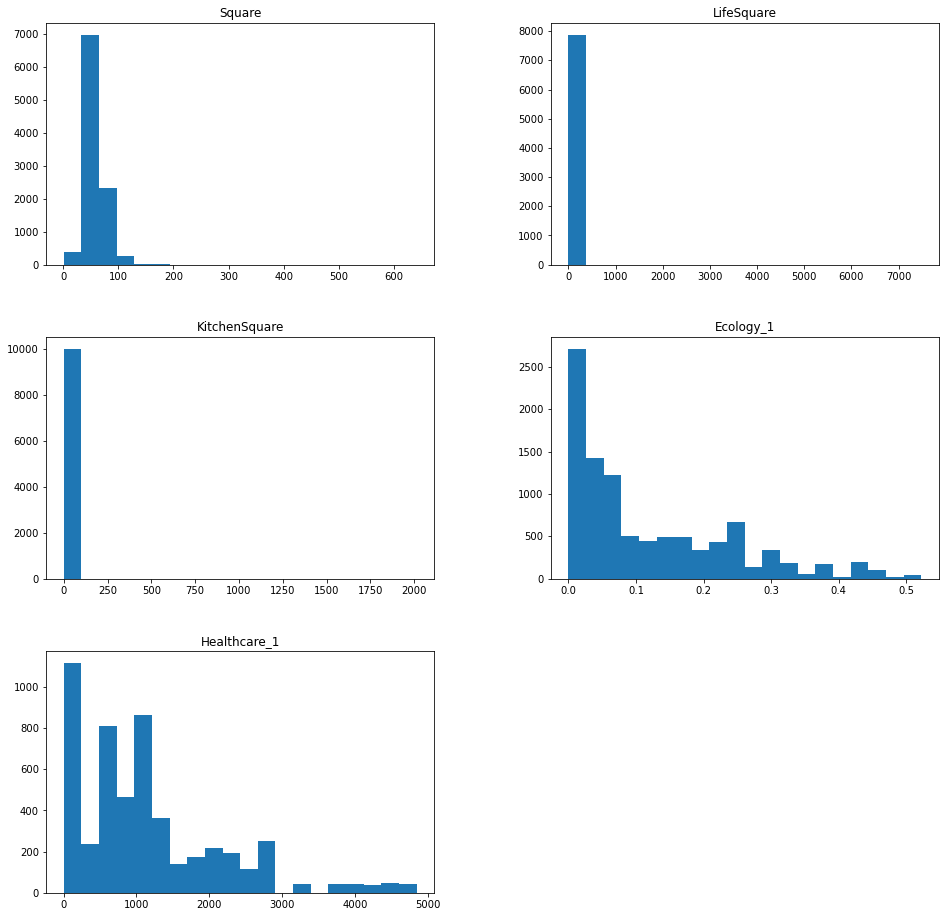

In [4]:
show_features()

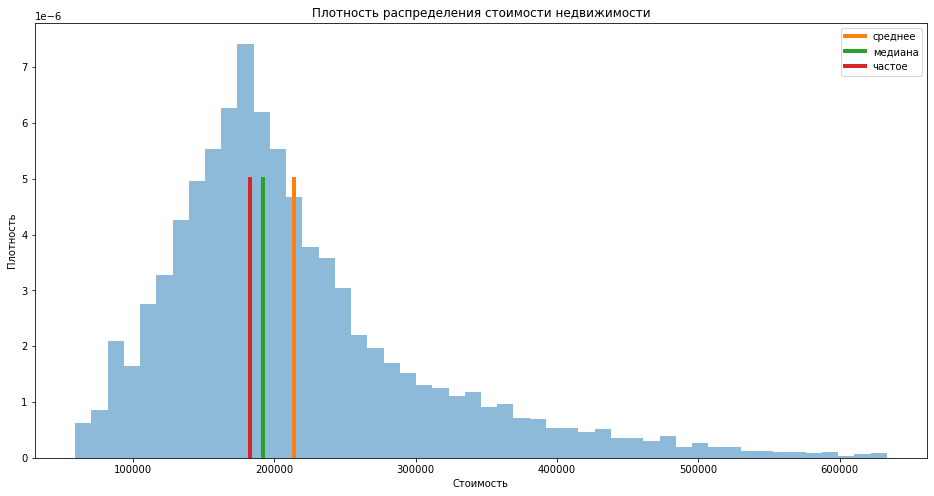

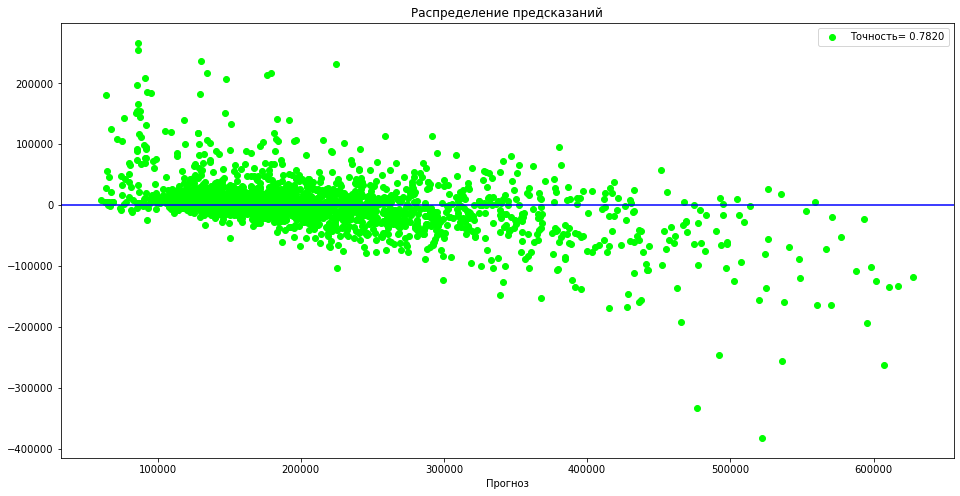

In [5]:
show_price()
show_pred()

#### Точность предсказаний

In [6]:
r2_score(y_test, model.predict(X_test))

0.7819855356619607